#Preliminary operations

In [ ]:
#@title Drive mount

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow import keras
tfk = tf.keras
tfkl = tf.keras.layers

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

In [ ]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


#Data access

In [ ]:
#@title Functions needed to access data
def get1image(name='img_name'):
  ''' 
    It returns the the requested image in form of a batch of 1 element, processed as those in the model creation.
    It will be a ndarray in the shape: (1, 224, 224, 3)
    The values are in the range 0-255
  '''
  generator = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = None,
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)
  idx = generator.filenames.index(name)
  
  for i in range(idx):
    batch = next(generator)
  
  batch = next(generator)
  image = batch
  #print("(Input) image shape:", image.shape)

  image_2_show = batch[0]/255
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.double(image_2_show),cmap='gray')
  return image

def get_next_batch(generator, image_index=0): #function to take one batch from generator, to take an image we consider first element of the batch
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)


  # Visualize only the first sample
  image = image[image_index]
  target = target[image_index]
  target_idx = np.argmax(target)
  
  idx = (generator.batch_index -1) * generator.batch_size
  print(generator.filenames[idx : idx + generator.batch_size][image_index])
  
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  image_2_show = image[:,:,0]
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.double(image_2_show),cmap='gray')

  return batch, image_2_show, target
'''
def get_next_image(generator):
  batch = next(generator)
  image = batch
  idx = generator.batch_index-1
  name = generator.filenames[idx]
  label = generator.labels[idx]
  #image_2_show = batch[0]/255
  #fig = plt.figure(figsize=(6, 4))
  #plt.imshow(np.double(image_2_show),cmap='gray')
  return image, name, label, idx
'''

def get_next_image(generator):
  #restituisce un immagine su tre canali, i pixel sono nel range 0-1
  im = next(generator)
  im = im[0]
  im = im[0,:,:,:]/np.amax(im)
  return im

def visualize_images(batch):
  # generator.next() provides [images, labels] (with dimension batch_size)

  images = batch[0]
  labels = np.argmax(batch[1], axis=-1)

  size,scale = 224, 10
  c=8
    
  for i in range(8):
    f, axs = plt.subplots(1,c, figsize=(20,20))
    axs.flat
    xs = images[i*8:i*8+8]
    for j in range(c):
      img = xs[j]
      axs[j].imshow(img/255)
      axs[j].axis('off')
      


#Functions to invert images if needed

In [ ]:
#@title Find inverted images
'''
#with normalized images (pixels 0-1)
def get_bg_angle(bkgr, angle):
  for _, row in enumerate(angle):
    for _, pix in enumerate(row):
      if pix<0.1:
        bkgr.append(0)
      elif pix>0.9:
        bkgr.append(1)
  return bkgr

def is_inverted(im):
  #input is a 224x224 image on 3 channels (224,224,3)
  #pixels should range in 0-1
  top_left = im[0:5,0:5,0]
  top_right = im[0:5,-5:225,0]
  bottom_left = im[-5:225, 0:5,0]
  bottom_right = im[-5:225,-5:225,0]

  background = []
  for _,ang in enumerate([top_left, top_right, bottom_left, bottom_right]):
    background = get_bg_angle(background, ang)

  if sum(background) < 0.5*len(background):
    inv = 0
  else: 
    inv = 1
  return inv

def invert(im):
  if is_inverted(im/np.amax(im)):
    return 1-im
  else:
    return im'''


# pixels ranging 0-255
def get_bg_angle(bkgr, angle):
  for _, row in enumerate(angle):
    for _, pix in enumerate(row):
      if pix<255*0.2:
        bkgr.append(0)
      elif pix>255*0.8:
        bkgr.append(1)
  return bkgr

def is_inverted(im):
  #input is a 224x224 image on 3 channels (224,224,3)
  #pixels should range in 0-255
  top_left = im[0:5,0:5,0]
  top_right = im[0:5,-5:225,0]
  bottom_left = im[-5:225, 0:5,0]
  bottom_right = im[-5:225,-5:225,0]

  background = []
  for _,ang in enumerate([top_left, top_right, bottom_left, bottom_right]):
    background = get_bg_angle(background, ang)

  if sum(background) < 0.5*len(background):
    inv = 0
  else: 
    inv = 1
  return inv

def invert(im):
  if is_inverted(im):
    return 255-im
  else:
    return im

#Generators creation

In [ ]:
#@title Data parameters
data_hyperparameters = {
    'batch_size': 1,
    'resized_shape_height': 224,
    'resized_shape_width': 224,
    'color_mode': 'rgb'
}

n_channels = 1 if data_hyperparameters['color_mode']=='grayscale' else 3
input_shape = (data_hyperparameters['resized_shape_height'],data_hyperparameters['resized_shape_width'],n_channels) 

In [ ]:
#@title Create data generator: both with and without inversion check
train_dir = '/content/gdrive/MyDrive/splitted_dataset/train'
validation_dir = '/content/gdrive/MyDrive/splitted_dataset/val'

train_set = ImageDataGenerator().flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = 64,# data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

train_set_inv = ImageDataGenerator(preprocessing_function=invert).flow_from_directory(directory = train_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = 64, #data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

validation_set = ImageDataGenerator().flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

validation_set_inv = ImageDataGenerator(preprocessing_function=invert).flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)

Found 11124 images belonging to 3 classes.
Found 11124 images belonging to 3 classes.
Found 1253 images belonging to 3 classes.
Found 1253 images belonging to 3 classes.


#Now look at the results on a 64 images batch

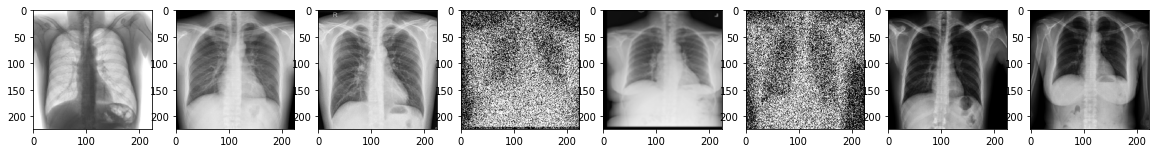

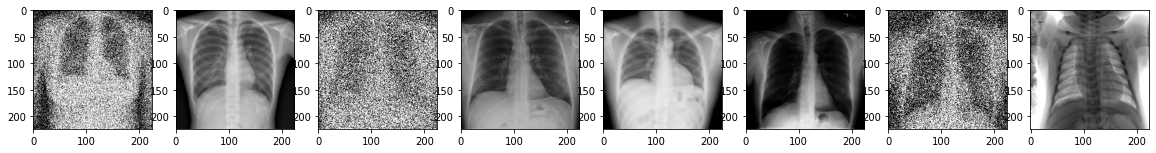

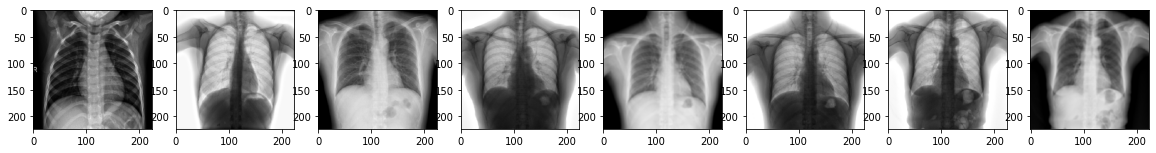

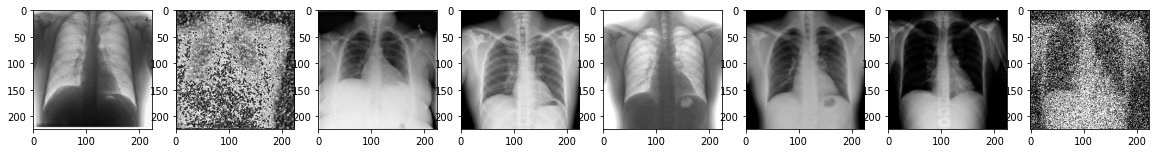

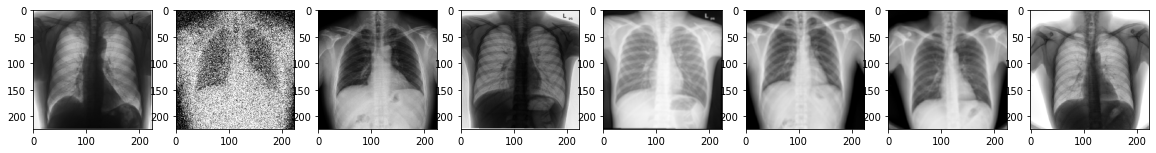

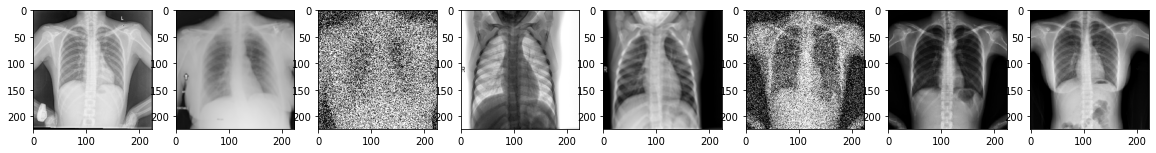

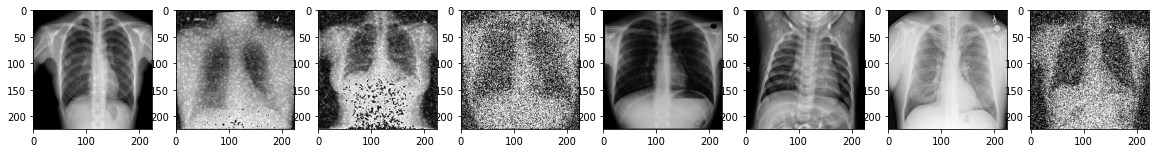

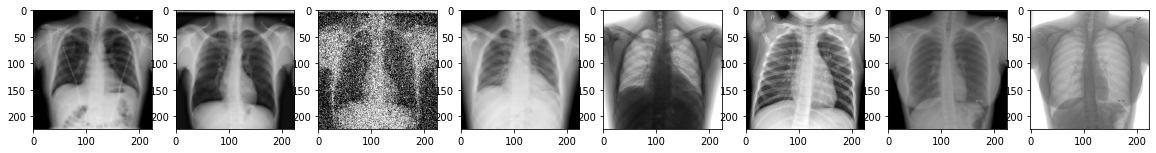

In [ ]:
visualize_images(train_set.next())

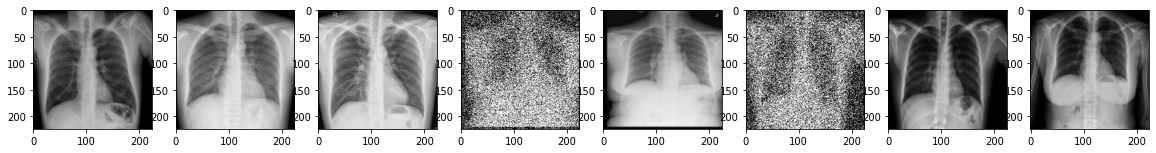

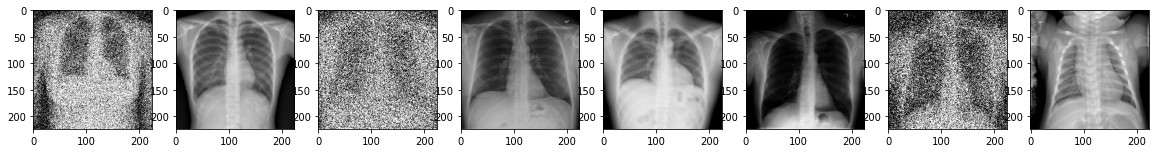

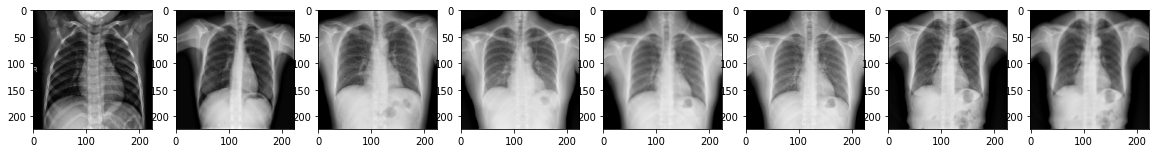

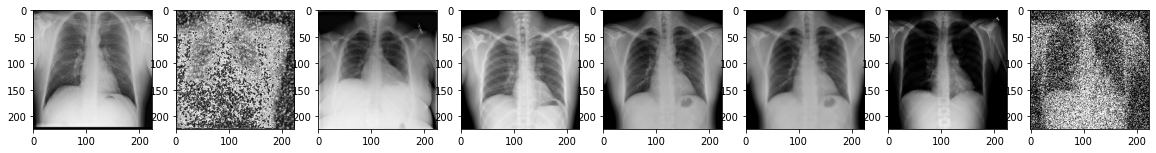

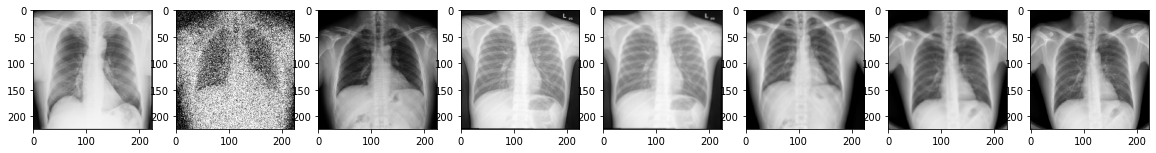

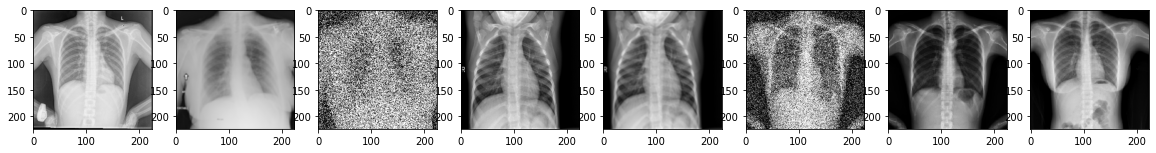

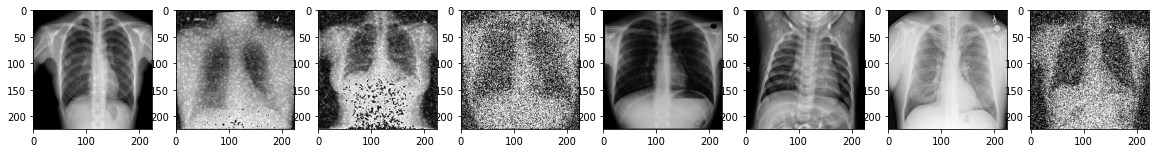

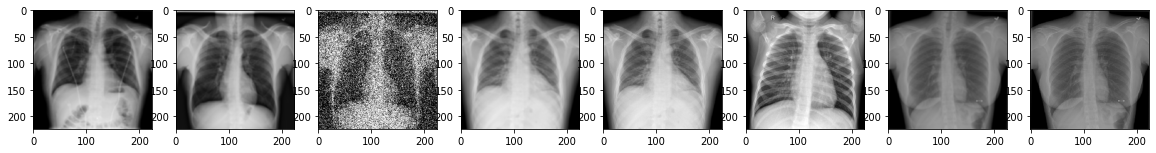

In [ ]:
visualize_images(train_set_inv.next())

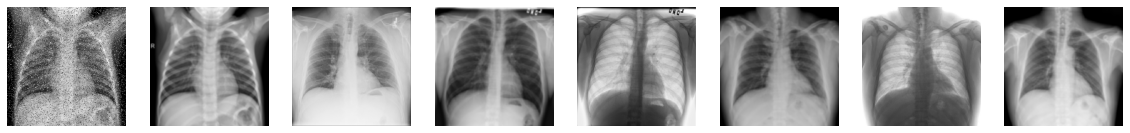

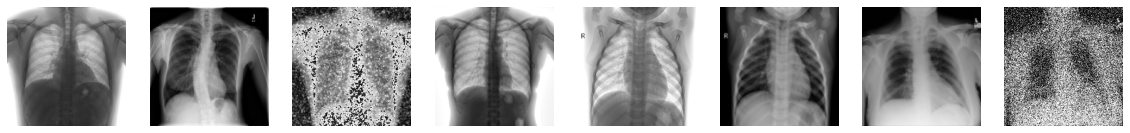

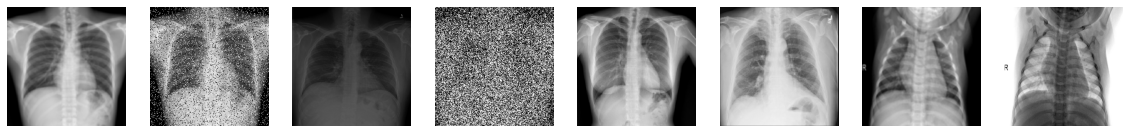

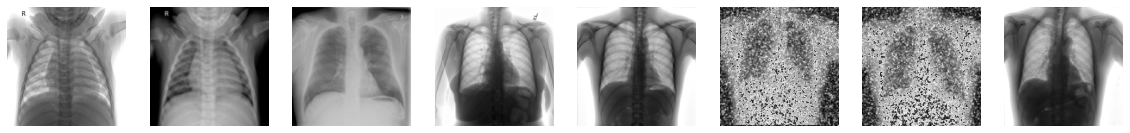

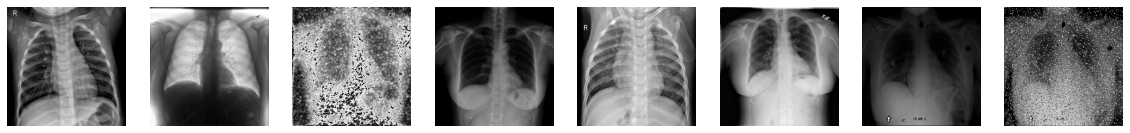

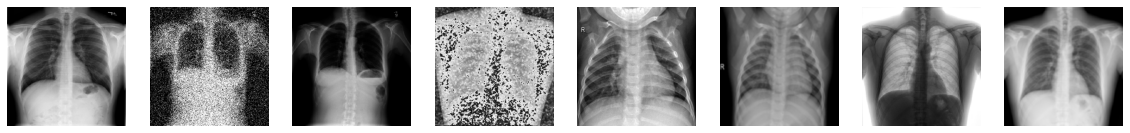

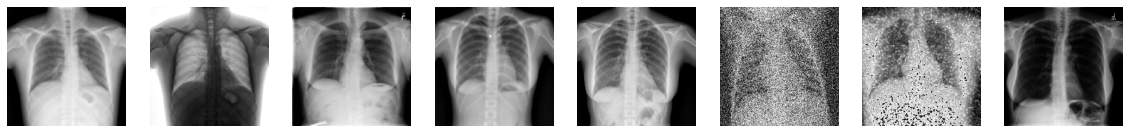

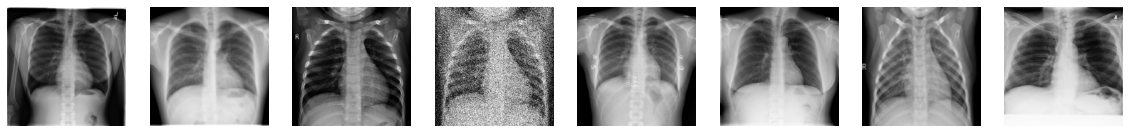

In [ ]:
visualize_images(train_set.next())

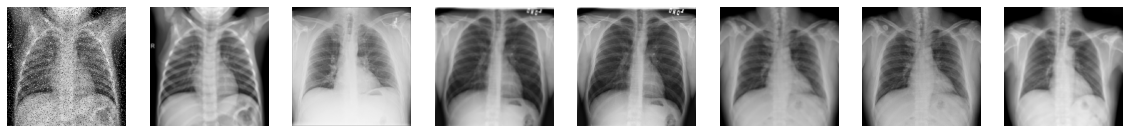

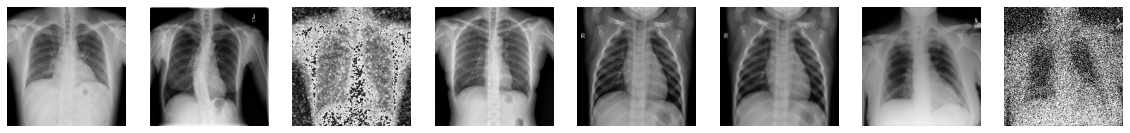

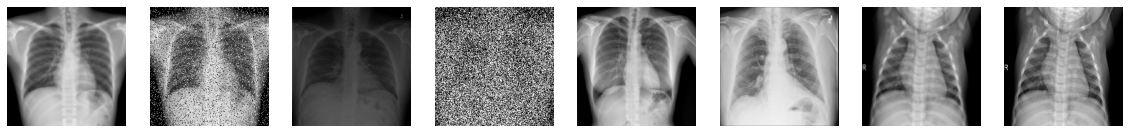

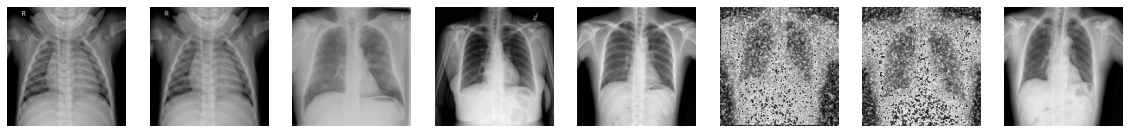

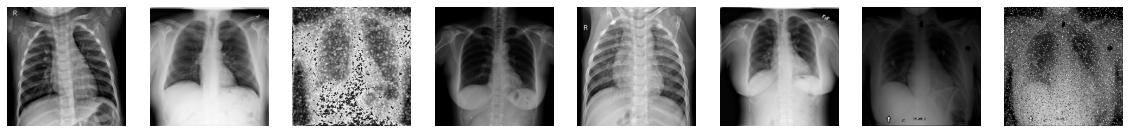

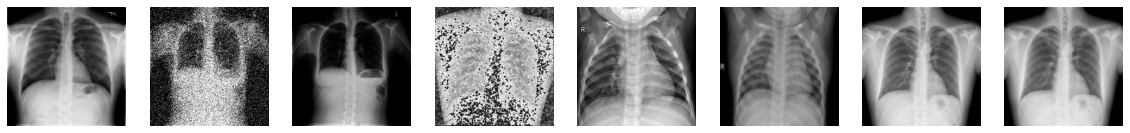

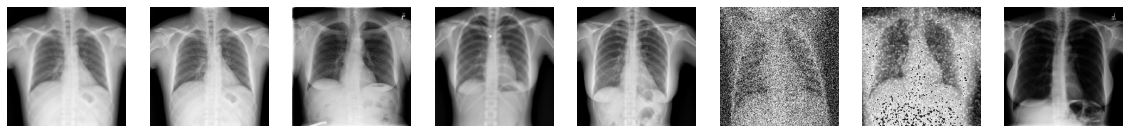

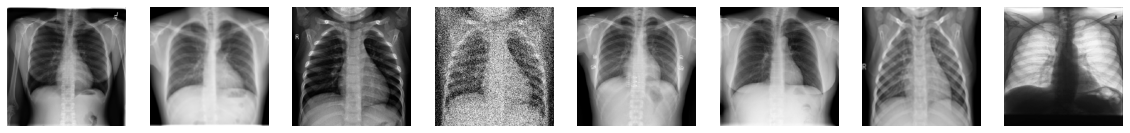

In [ ]:
visualize_images(train_set_inv.next())